In [12]:
import os
import numpy as np
import cv2
import warnings
warnings.filterwarnings('ignore')

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Image preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Model building
import tensorflow as tf
from tensorflow.keras import models, layers, utils
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical

# Model saving
import pickle
from keras.models import load_model


#### Data importing and exploration

In [3]:
# Images imporing function
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def import_imgs(dir):
    data = []
    for label in labels:
        path = os.path.join(dir, label) #getting imgs from label directories
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img)) # getting images
                img = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY) # Converting to gray
                img_resized = cv2.resize(img,(img_size, img_size)) # Resizing image
                data.append([img_resized, class_num]) # Appending image-class pairs to data list
            except Exception as e:
                print(e)
    return np.array(data)
                

In [4]:
train = import_imgs('../chest_xray/train')
test = import_imgs('../chest_xray/test')
val = import_imgs('../chest_xray/val')

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



#### Visualization

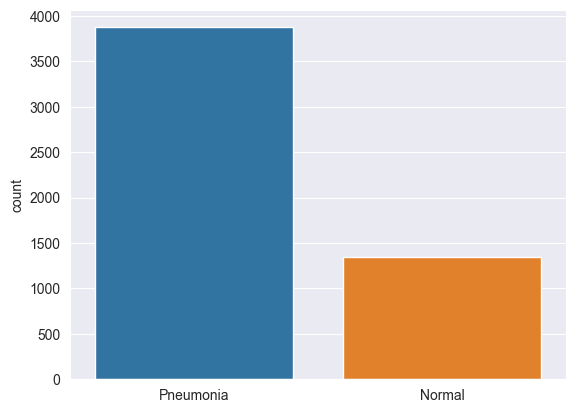

In [5]:
l = []
for i in train:
    if (i[1] == 0):
        l.append('Pneumonia')
    else:
        l.append('Normal')
sns.set_style('darkgrid')
sns.countplot(x=l)
plt.show()

Text(0.5, 1.0, 'NORMAL')

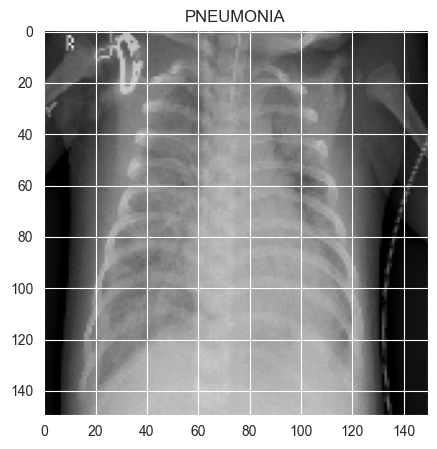

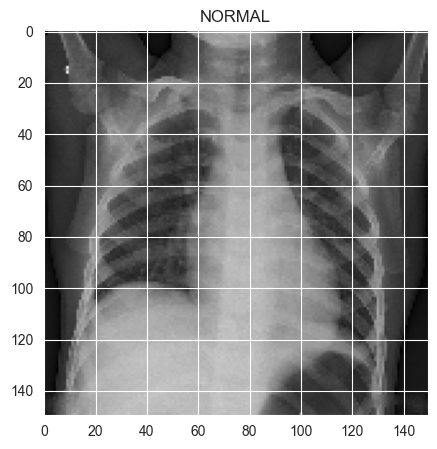

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize=(5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

#### Data split

In [7]:
X_train = []
y_train = []

X_test = []
y_test = []

X_val = []
y_val = []

for data, label in train:
    X_train.append(data)
    y_train.append(label)

for data, label in test:
    X_test.append(data)
    y_test.append(label)

for data, label in val:
    X_val.append(data)
    y_val.append(label)

In [8]:
# labels encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
y_val = lb.fit_transform(y_val)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

#### Data normalization for Deep Learning

In [9]:
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
X_val = np.array(X_val) / 255

In [10]:
# Resizing
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_train = np.array(X_train)

X_test = X_test.reshape(-1, img_size, img_size, 1)
X_test = np.array(X_test)

X_val = X_val.reshape(-1, img_size, img_size, 1)
X_val = np.array(X_val)

In [11]:
# Generating data to fix the imbalanced data
newdata = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#### Model training

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(32, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 32)       0

In [12]:
# Compiling model and learning rate tuning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate = ReduceLROnPlateau(monitor='val_accuracy', min_lr=.00001, factor=.3)

In [13]:
history = model.fit(newdata.flow(X_train, y_train, batch_size=16), epochs=10, validation_data=newdata.flow(X_val, y_val), callbacks=[learning_rate])

Epoch 1/10
326/326 [==============================] - 422s 1s/step - loss: 0.4801 - accuracy: 0.7653 - val_loss: 0.6960 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
326/326 [==============================] - 346s 1s/step - loss: 0.3711 - accuracy: 0.8206 - val_loss: 1.0628 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
326/326 [==============================] - 319s 978ms/step - loss: 0.2973 - accuracy: 0.8673 - val_loss: 1.0262 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/10
326/326 [==============================] - 303s 929ms/step - loss: 0.2584 - accuracy: 0.8855 - val_loss: 1.3838 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/10
326/326 [==============================] - 308s 944ms/step - loss: 0.2463 - accuracy: 0.8982 - val_loss: 1.4308 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
326/326 [==============================] - 303s 929ms/step - loss: 0.2229 - accuracy: 0.9043 - val_loss: 0.6871 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/10
326/326 [==============================] 

#### Model evaluation

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Test loss: {loss:.4f}')

20/20 [==============================] - 10s 512ms/step - loss: 0.3412 - accuracy: 0.8766
Test accuracy: 87.66%
Test loss: 0.3412


In [16]:
# Saving model and history
model.save('model.h5')

with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Saved


In [20]:
# Loading the model and training history
model = load_model('model.h5')

with open('training_history.pkl', 'rb') as file:
    history = pickle.load(file)

In [21]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Test loss: {loss:.4f}')

20/20 [==============================] - 10s 497ms/step - loss: 0.3412 - accuracy: 0.8766
Test accuracy: 87.66%
Test loss: 0.3412


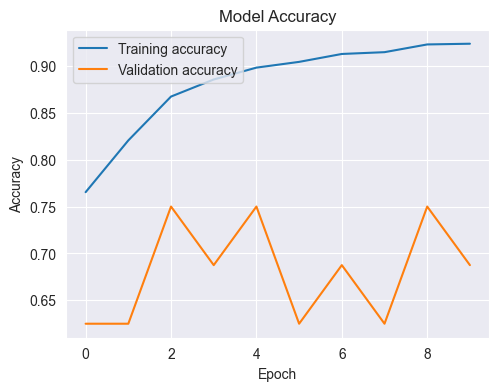

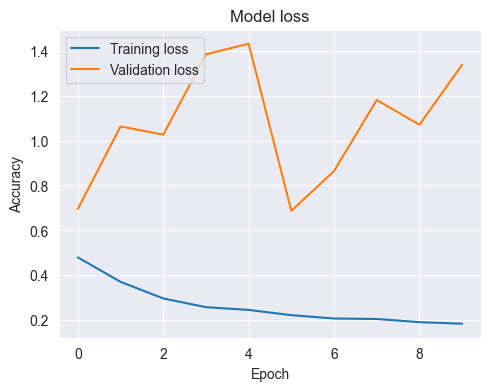

In [26]:
# Depicting history
# Accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')


20/20 [==============================] - 10s 502ms/step


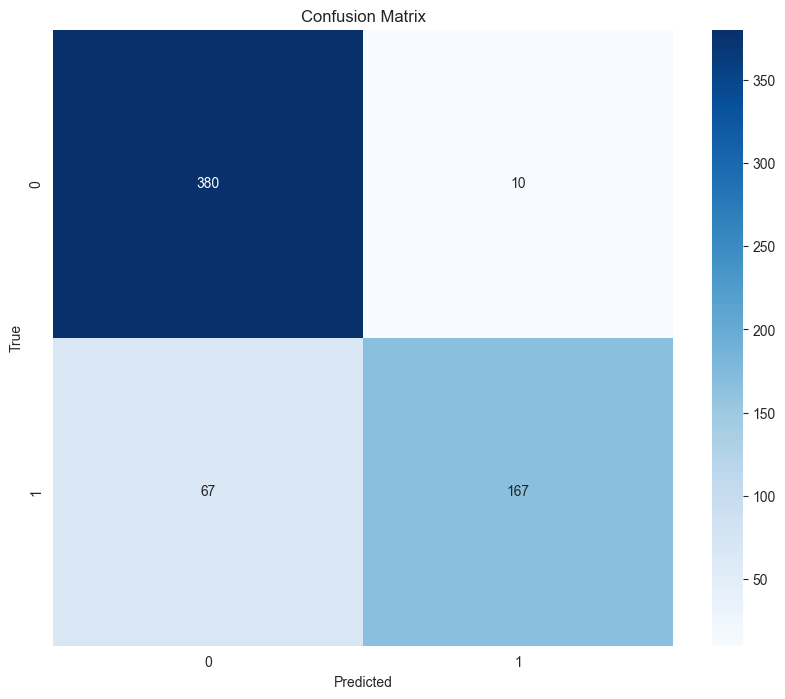

In [41]:
# Getting predictions, confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [44]:
# Classification report
cr = classification_report(y_true, y_pred_classes)
print(cr)

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       390
           1       0.94      0.71      0.81       234

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



#### Fine-tuning the model to get better performance

In [13]:
# Adding dropout layers and checkpoints
model = models.Sequential()
model.add(layers.Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(32, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 32)       0

In [14]:
# Compiling model and learning rate tuning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate = ReduceLROnPlateau(monitor='val_accuracy', min_lr=.00001, factor=.3)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [15]:
history = model.fit(newdata.flow(X_train, y_train, batch_size=16), epochs=10, validation_data=newdata.flow(X_val, y_val), callbacks=[learning_rate, checkpoint])

Epoch 1/10
326/326 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.7640
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to best_model.h5
326/326 [==============================] - 394s 1s/step - loss: 0.4928 - accuracy: 0.7640 - val_loss: 1.0124 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
326/326 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.8491
Epoch 2: val_accuracy did not improve from 0.62500
326/326 [==============================] - 335s 1s/step - loss: 0.3313 - accuracy: 0.8491 - val_loss: 1.3279 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
326/326 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0.8769
Epoch 3: val_accuracy improved from 0.62500 to 0.68750, saving model to best_model.h5
326/326 [==============================] - 321s 985ms/step - loss: 0.2768 - accuracy: 0.8769 - val_loss: 1.4543 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/10
326/326 [==============================] - 

#### Evaluation

In [16]:
# Saving history

with open('training_history-2.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [33]:
# Loading best model
best_model = models.load_model('best_model.h5')

In [34]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Test loss: {loss:.4f}')

20/20 [==============================] - 10s 483ms/step - loss: 0.3693 - accuracy: 0.8093
Test accuracy: 80.93%
Test loss: 0.3693


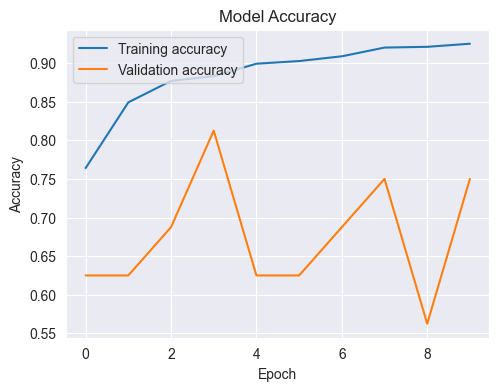

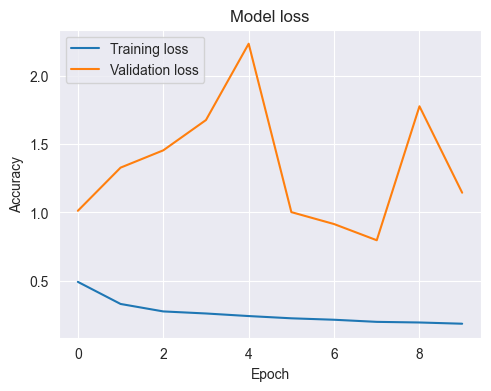

In [36]:
# Depicting history
# Accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')


20/20 [==============================] - 11s 525ms/step


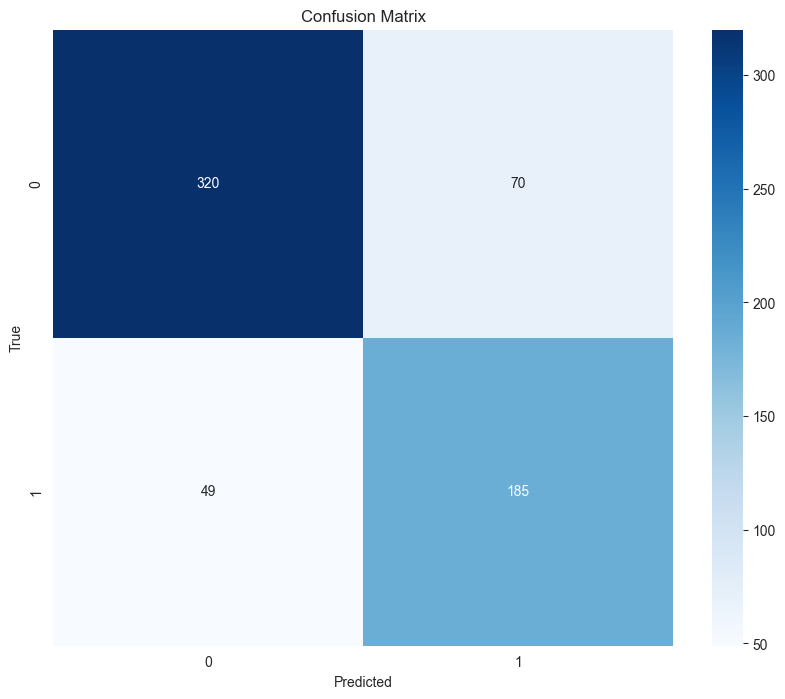

In [37]:
# Getting predictions, confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [38]:
# Classification report
cr = classification_report(y_true, y_pred_classes)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       390
           1       0.73      0.79      0.76       234

    accuracy                           0.81       624
   macro avg       0.80      0.81      0.80       624
weighted avg       0.81      0.81      0.81       624



#### Fine-tuning 2

In [44]:
# Editing the dropout layers and increasing # epochs
model = models.Sequential()
model.add(layers.Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(32, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 128)     1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 32)      

In [45]:
# Compiling model and learning rate tuning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate = ReduceLROnPlateau(monitor='val_accuracy', min_lr=.00001, factor=.3)
checkpoint = ModelCheckpoint('best_model-2.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [46]:
history = model.fit(newdata.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=newdata.flow(X_val, y_val), callbacks=[learning_rate, checkpoint])

Epoch 1/15
163/163 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.7563
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to best_model-2.h5
163/163 [==============================] - 357s 2s/step - loss: 0.5239 - accuracy: 0.7563 - val_loss: 1.0272 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8288
Epoch 2: val_accuracy did not improve from 0.81250
163/163 [==============================] - 327s 2s/step - loss: 0.3675 - accuracy: 0.8288 - val_loss: 2.5320 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8487
Epoch 3: val_accuracy did not improve from 0.81250
163/163 [==============================] - 324s 2s/step - loss: 0.3151 - accuracy: 0.8487 - val_loss: 2.4185 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0

#### Evaluation

In [47]:
# Saving history
with open('training_history-3.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [48]:
# Loading best model
best_model = models.load_model('best_model.h5')

In [49]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Test loss: {loss:.4f}')

20/20 [==============================] - 10s 509ms/step - loss: 0.3693 - accuracy: 0.8093
Test accuracy: 80.93%
Test loss: 0.3693


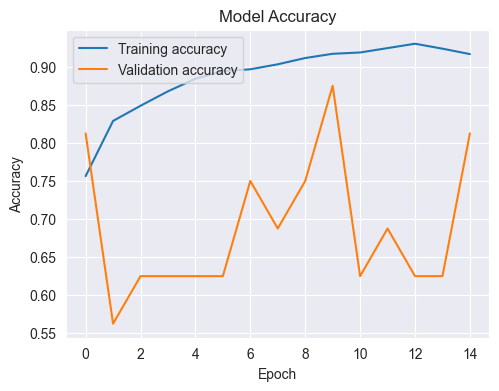

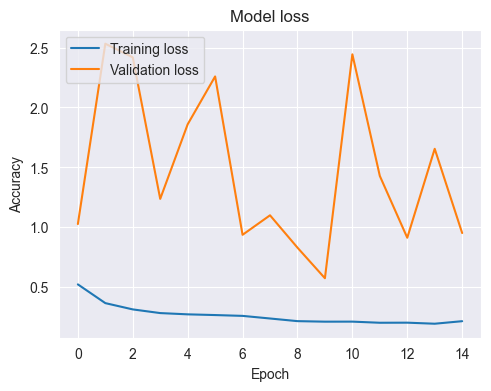

In [50]:
# Depicting history
# Accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')


20/20 [==============================] - 11s 530ms/step


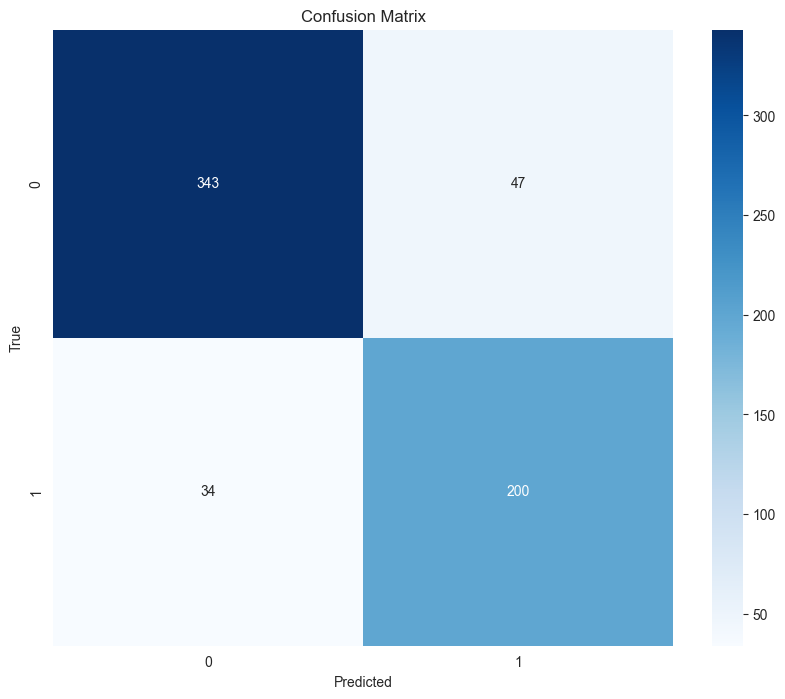

In [51]:
# Getting predictions, confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [52]:
# Classification report
cr = classification_report(y_true, y_pred_classes)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       390
           1       0.81      0.85      0.83       234

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.86       624
weighted avg       0.87      0.87      0.87       624



#### This is the best peroformance reached so far using CNN
##### In order to get better proformance, pre-trained models can be used, like ResNet as VGG